In [6]:
pd.options.mode.chained_assignment = None
from matplotlib import lines
from pandas.api.types import CategoricalDtype
import funclib as flib

Latin to common conversion file

In [2]:
data_dir = "../.."
latin2common = pd.read_csv("{}/data/latin2common_shortened.txt".format(data_dir),sep="\t").set_index("Species").to_dict()["Common_names"]

Read data

In [3]:
alphas = pd.DataFrame()
mut_types = "mod,gc-BGC-unaffected,W>S,S>W".split(",")
#mut_types = "mod,C>A,C>G,C>T,T>A,T>C,T>G".split(",")

for g in ["Mammals.Homo_sapiens", "Birds.Gallus_gallus", "Snakes.Thamnophis_elegans"]:
    alpha_dir = "{}/scripts/alphas".format(data_dir)
    merged_alphas = flib.parse_alpha_tsvs(g, alpha_dir)
    merged_alphas["group"] = g
    alphas = pd.concat([merged_alphas, alphas])

alphas = alphas.reset_index(drop=True)
alphas = alphas[alphas.mut_type.isin(mut_types)]
alphas["common_name"] = [latin2common[sp] for sp in alphas.species]
species = alphas.species.unique().tolist()

Plot for mutation types

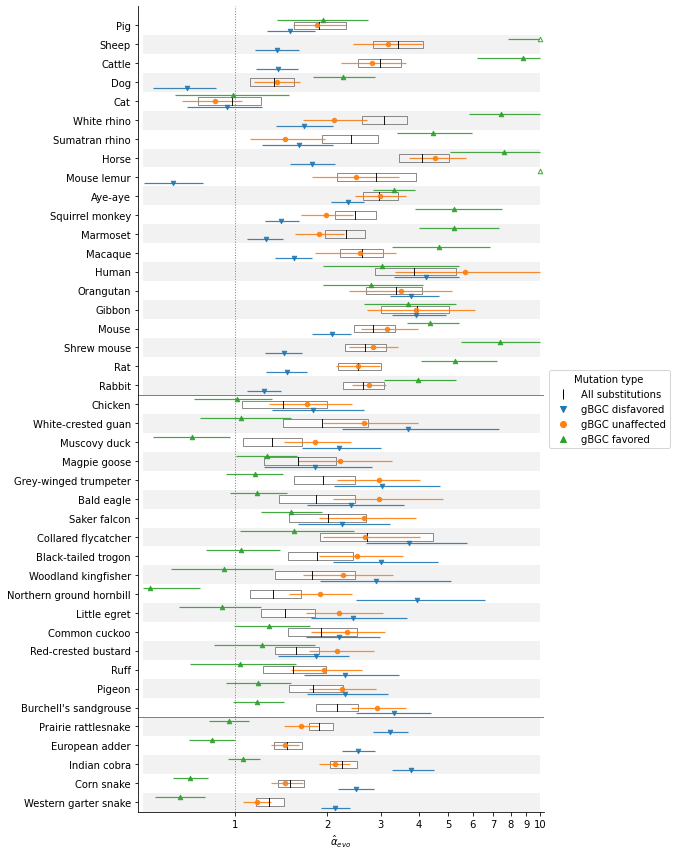

In [11]:
f,ax = plt.subplots(figsize=[9.5,12])

pad = 0.3
n = len(mut_types)-1
min_x = 0.5
max_x = 10
c_array = ["C{}".format(i) for i in range(n)]
#marker_dict = {"C>G":"o", "T>A":"o", "C>A":"v", "T>C":"^", "C>T":"v","T>G":"^"}
#mut_order = ["C>A", "C>T", "C>G", "T>A", "T>C", "T>G"]
marker_dict = {"W>S":"^", "gc-BGC-unaffected":"o", "S>W":"v"}
mut_order = ["S>W","gc-BGC-unaffected","W>S"]
cat_mut_order = CategoricalDtype(mut_order, ordered=True)

for i,(sp,adf) in enumerate(alphas.groupby("species")):

    isp = species.index(sp)
    x_coor = np.linspace(isp-pad,isp+pad,n)
    
    # Alpha for all mutations
    mod = adf[adf.mut_type=="mod"]
    lwr,mid,upr = mod[["alpha_lwr","alpha","alpha_upr"]].values[0]
    mod_margin = 0.2
    
    ax.plot([mid, mid],[isp-mod_margin,isp+mod_margin],
            color="black",linewidth=1, alpha=0.9)
    
    ax.fill_between([lwr,upr], isp-mod_margin,isp+mod_margin, 
                    color="white", edgecolor="gray", alpha=0.9)
    
    # Alpha for mutation types
    df = adf[adf.mut_type!="mod"]
    df["mut_type"] = df["mut_type"].astype(cat_mut_order)
    df = df.sort_values("mut_type")
    alpha_values = flib.replace_values(df.alpha, min_x, max_x)
    markers = [marker_dict[m] for m in df.mut_type]
    
    for i2,alpha_v in enumerate(alpha_values):
        ax.scatter(x = alpha_v, y = x_coor[i2], edgecolor = c_array[i2], 
                   color= "white" if alpha_v==min_x or alpha_v==max_x else c_array[i2],
                   s=20, alpha=0.9, marker=markers[i2],zorder=10)
        
    ax.hlines(y=x_coor, xmin=flib.replace_values(df.alpha_lwr, min_x, max_x), xmax=flib.replace_values(df.alpha_upr, min_x, max_x), 
              color = c_array, linewidth=1.2, alpha=0.9,zorder=1)

    # Add the patch to the Axes
    ax.fill_between([min_x,max_x], i-0.5,i+0.5, 
                    edgecolor='none', facecolor='gray' if i%2==0 else "none", 
                    alpha=0.1, zorder=1)

# Legends
format_labels = {"mod":"All","W>S":"gBGC favored","S>W":"gBGC disfavored","gc-BGC-unaffected":"gBGC unaffected"}

for i,m in enumerate(df.mut_type):
    ax.scatter(5e3,1e3,c="C{}".format(i),
               label=format_labels[m] if m in format_labels else m,
               marker=marker_dict[m])
    
vertical_line = lines.Line2D([], [], color='black', marker='|', linestyle='None',
                             markersize=10, markeredgewidth=1)
handles, labels = ax.get_legend_handles_labels()
handles = [vertical_line] + handles
labels = ["All substitutions"] + labels
ax.legend(title="Mutation type",loc='center left', bbox_to_anchor=(1, 0.5), 
          labels = labels, handles = handles)

if len(mut_order)>3:
    ax2 = ax.twinx()
    for m,n in zip(["^", "o", "v"], ["gBGC favored", "gBGC unaffected", "gBGC disvafored"]):
        ax2.scatter(5e3, 1e3, marker=m, label=n, color="black")
    ax2.get_yaxis().set_visible(False)
    ax2.legend(title="gBGC",loc='center left', bbox_to_anchor=(1, 0.43))

# Division between taxa
for y in [5,22]:
    ax.axhline(y=y-0.5,linewidth=1,color="gray")
    
# Alpha 1
ax.axvline(x=1,color="gray",linestyle="dotted",linewidth=1)    

# Style
ax.set_xlim([min_x-0.02,max_x+0.25])
ax.set_xscale('log', base=2)
ax.set_xticks(range(1,max_x+1))
ax.set_xticklabels(range(1,max_x+1))
ax.set_ylim([-0.5,len(species)])
ax.set_yticks(range(len(species)))
ax.set_yticklabels([latin2common[sp] for sp in species])
ax.set_xlabel(r"$\hat{\alpha}_{evo}$")
sns.despine()
plt.tight_layout()

#plt.savefig("../pdfs/Figure_SX_alpha_mutation_types.pdf")

Scatter plots

In [ ]:
alphas["taxon"] = [g.split(".")[0] for g in alphas.group]
datasets = {}
for m in mut_types:
    datasets[m] = alphas[alphas.mut_type==m].reset_index(drop=True)

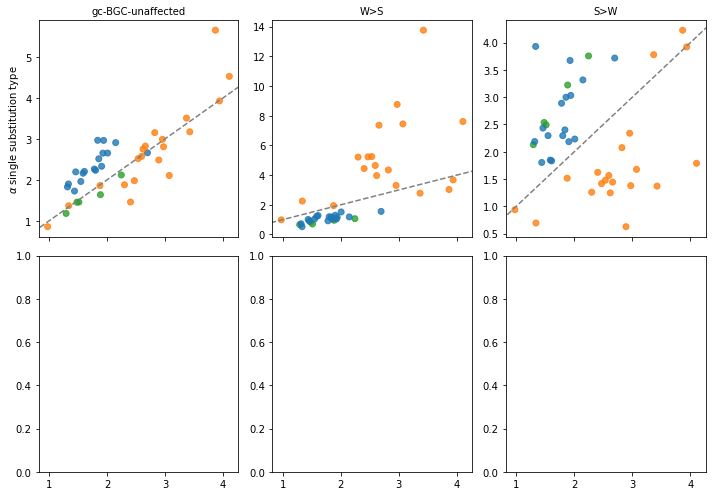

In [13]:
f,axs0 = plt.subplots(2,3,sharex=True,figsize=[10,7])
axs = axs0.reshape(-1)

palette = {"Birds":"C0","Mammals":"C1","Snakes":"C2"}
c_array = [palette[t] for t in datasets["mod"].taxon]

for i,m in enumerate(mut_types[1:]):

    ax = axs[i]
    scatter = ax.scatter(datasets["mod"].alpha,datasets[m].alpha,c=c_array,alpha=0.8)
    flib.identity_line(ax=ax,color="gray")
    ax.set_title(m,fontsize=10)
    if i>2:
        ax.set_xlabel(r"$\alpha$ all substitutions")
    if i==0 or i==3:
        ax.set_ylabel(r"$\alpha$ single substitution type")
    if i==5:
        legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
        ax.add_artist(legend1)
    
        
plt.tight_layout()
#plt.savefig("../pdfs/Figure_SX_alpha_mutation_types_singleclasses_scatter.pdf")